### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2019 ###

# Stock Trading Optimization#

#### Jacob Makola (makola@wisc.edu), Finley Myers (fmyers@wisc.edu), Aaron Zhang(zzhang867@wisc.edu), and Lucas Laibly (laibly@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [General Model](#2. General Model)
     1. [General Mathematical Model](#2a.- General Mathematical Model )
     1. [Solution](#b.-Solution)
     1. [Results](#c.-Results)
1. [Moving Average](#3.-General)
     1. [Mathematical Model](#a.-Mathematical)
     1. [Solution](#b.-Solution)
     1. [Results](#c.-Results)
1. [Regularization](#4.-Results-and-discussion)
    1. [Mathematical Model](#a.-Mathematical)
    1. [Solution](#b.-Solution)
    1. [Results](#c.-Results)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

Our project is centered around the stock market and includes three different scenarios that all give insight on when to buy and sell and how different factors affect a trade. Our group began this project by selecting a problem that has monetary significance, and therefore arrived on trading stocks. Next, we chose to focus on the five largest technology-based stocks on the NASDAQ: Amazon, Facebook, Apple, Microsoft, and Google.

Our first scenario was creating a model that would output when to buy and sell each type of stock over the course of five days. Data was taken directly from real stock prices for each company from March 25th, 2019 to March 29th, 2019. In this scenario, we initially started with $100,000 dollars and the goal was to maximize the amount of cash on hand by the fifth and final day.

Next, we decided to re-create an actual strategy that stock traders often utilize. This method is the moving average, and for the sake of simplicity, we used Amazon stock data over the course of a month to create the moving average. Essentially, the moving average curve tells traders when to buy and sell stock. A trader will often buy and sell when the trend of the actual price crosses the moving average curve; typically, the price crosses the curve at a low or high point (more details in the moving average).

Lastly, we created a tradeoff model for Amazon stock that simply shows how a trader’s return is affected when he or she must endure some cost to make a trade. This cost factor is very common on trading websites such as https://www.ally.com/invest/ where the cost per trade is about $5. Additionally, this cost within our model can also be inferred as the cost of “obtaining information” through sources such as financial consultant. 

All three of these models can be used as tools in order to better understand the stock market and the timing of trades. 


## 2. General Model ##

The general model represents the heart of our project. We looked to maximize the amount of money that could be potentially attained after one week of stock trading. Much like the traveling salesman problem, this is grossly impossible on the surface. So to make it more manageable, the assumptions we make are that:

1. We know how much the stock is going to sell for on each closing day
2. We set boundaries that a person cannot go broke (have less than 0 dollars) to buy stock and
3. Our starting amount of money on hand to buy stock is 100,000.

With these assumptions in mind, we begin to think of how to strucutre our base model. In the following program we set our first day seperate from the rest of the week tradings. This is because on the first day we have nothing to sell, and we should only buy. With the current model, we can more accurately force actions of buying and selling to occur through out the set amount of time. 

In [1]:
# How much money on hand that we have to work with
initialCash = 100000

using JuMP, Cbc, NamedArrays

# total number of days
days = [1, 2, 3, 4, 5]

# Amazon, Facebook, Mircosoft, Google, Apple -- In Order
stocks = [:am, :f, :m, :g, :ap]

# Data - One week stock value
values = NamedArray(
[1809.07 168.26 118.76 1188.04 190.35
1810.54 170.79 119.02 1184.24 192.54
1823.97 173.56 119.46 1193.36 194.93
1824.93 177.06 120.05 1206.19 195.76
1831.13 176.45 119.99 1214.68 196.57 ], (days, stocks), ("Days", "Stocks"))

m = Model(solver=CbcSolver())

# We can sell stocks
@variable(m, sell[days, stocks] >= 0,Int)

# We buy buy stock
@variable(m, buy[days, stocks] >= 0,Int)

# We can hold our current portfolio from one day to the next
@variable(m, hold[days,stocks] >= 0,Int)

# Inital amount of money at hand to purchase stock
@variable(m, cash[days] >= 0)


@constraint(m, hold_initial[j in stocks], hold[1, j] == buy[1, j])

# The balance of money that we have on hand much be equivalent to the amount we started with
# minue that of what we bought (per value)
@constraint(m, cash[1] == initialCash - sum(values[1, j] * buy[1, j] for j in stocks))

# On our first day we cannot sell anything because we dont have anything to sell
@constraint(m, sell_initial[j in stocks], sell[1, j] == 0)

# How much we buy on our first day must be less than how much money we have started with
@constraint(m, sum(values[1, j] * buy[1, j] for j in stocks) <= initialCash)

# Our hold for the current day must be equal to that of how much we held on our day previously plus how much 
# we bought for the day minus the amount we sold for the day as well. 
@constraint(m, hold_constraint[i in 2:5, j in stocks], hold[i, j] == hold[i - 1, j] + buy[i, j] - sell[i, j])

# To manage how much money we have moving from one day to next
@constraint(m, cash_constraint[i in 2:5], 
                cash[i] == cash[i - 1]  # currrent day's money on hand equal to amount from the previous day
                        + sum(values[i, j] * sell[i, j] for j in stocks) # plus our sold for the day
                        - sum(values[i, j] * buy[i, j] for j in stocks)) # minus how much we bought for the day

# How much we can buy is equal to the cost of the stock we want but must be less than how much money we have
# IMPORTANT : Our model does not supprot gambling (going into debt to buy stock in hopes of it paying off later)
@constraint(m, buy_constraint[i in 2:5], sum(buy[i, j] * values[i, j] for j in stocks) <= cash[i])

# How much we can sell depends on how much we are currently holding in our portfolio.
# We cannot sell what we do not own
@constraint(m, sell_constraint[i in 2:5, j in stocks], sell[i, j] <= hold[i - 1, j])

# On the last day, we sell everything we are holding for maximum profit in a singular trading week
@constraint(m, sum(hold[5, j] for j in stocks) == 0)

@objective(m, Max, cash[5])
solve(m)

returnVal = getobjectivevalue(m)
println("Portfolio return after one week ", returnVal)

Portfolio return after one week 105594.70000000001


With our portfolio return value at $105,594 we have a 5% return. However, this percent just represents the total return among all of the stocks. Below we can see which stocks we are investing in and selling on days 1 through 5.

# 2a. General Mathematical Model

In our mathematical model there are a few things that we need to establish prior to getting any value. These being the base cases in which our program can run.

Firstly, we need a case that states we can only hold as much as we have bought, this will take the form of:
$$H_0 = b$$ 
Where $H_0$ is our inital hold, and b represents our purchase (or buy).

Secondly, we must also establish a way of tracking our day to day cash, this will be what allows us to make a purchase of stock (negative) and what grows our money on hand (positive). Here we have write an equation that will take the form of:
$$C = C_0 - b$$ 
Where C is our cash on hand, $C_0$ is our initial cash and b is still our buy. This is crucial information to be able to assess just how much we can buy and how much we are holding at any given time.

With these in place we can begin to process our bug constraint, the one which will handle all calculations post the first day of our simulation:
$$C_i = C_{i-1} + S - B$$
$$B_c = b * d \leq C_i$$
$$S_c \leq h_{i-1}$$

$$C= \text {Cash}\ $$
$$C_i = \text {Cash on first day}\ $$ 
$$B = \text {action of buying}\ $$ 
$$B_c = \text {Buy constraint, cannot buy for more money than we have}\ $$
$$S = \text {action of selling}\ $$
$$S_c = \text {Sell constraint, cannot sell what we do not have}\ $$ 
$$h = \text {how much we are holding}\ $$
$$d = \text {values of stock}\ $$


## 2b. General Model Solution ##
The solution to the problem is rather exhaustive as our general solution above looks at the volatility of going from the first day to the last day. This meaning, rather than make actions from the circumstances of each day, we look at where we start and then where we end. Regardless, our solution provides us insight that we are spending every last dollar we can, other than day 4. This is where the general soltuion falls through in that it knows the future. In a real time stock market trading scenario, one does not know the future. We cover this by making the assumption at the start that the program will assume to know the future and then "in real time" depecit what to buy and when to sell. 

Going back to what occurs on Day 4 is that we want to hold as much google and apple stock as possible, now we cannot sell what we just bought so here sell our current holdings, then buy our shares into Google and Apple. Between these two companies we will have the largest profit margain at the end of Day 5.

In [7]:
# How much money we have on hand after each day of buying/selling
getvalue(cash)

cash: 1 dimensions:
[1] = 53.55999999999382
[2] = 53.55999999999381
[3] = 53.55999999999381
[4] = 52773.75
[5] = 105594.70000000001

In [ ]:
# Which stocks we are buying into
getvalue(buy)

In [ ]:
# Which stocks we are selling on each day
getvalue(sell)

In [ ]:
# How much we are holding on each day
getvalue(hold)

## 2c. General Model Results ##

Our results conclude that the highest area for profit comes from our last two days of trading, the build up previously is the seek out a few dollars, but the real money maker falls within Apple and Google. If we were to illogically trust this code as truth, we could make a recommendation that Apple and Google are the safest and most profitable areas to put our money, however it will come to the models following to show if that is the case or not. For now, we have a 5% profit making in 5 days, and are sitting at a 105,000$. 

One can analyze the trends for the 5 days for each stock and observe that our solution goes hand in hand with this analysis. As a rule of thumb for the stock market: buy low and sell high! The maximum amount of money made will be when a stock is bought at a low price, and sold at a higher price. 

Facebook has highest degree of change from start (day 1) to finish (day 5) or starts low and ends high. With our current amount of money ($100,000) and the set amount of time (5 days) we can accurately depict how to maximize return rates of money with the given stocks.

Note that this scheduling problem is formed once information is known. For example, we used historical data for our scheduling data, and therefore this optimization solution will only hold if prices are known. One way to do this (without being a future teller) is to pay a consultant or an expert in the field. This payment is the cost of imperfect information, since the expert's prediction will not be 100% accurate. Additionally the amount of money we are willing to pay any consultant must be lower than your return value, otherwise we would lose money and the objective is to gain. This is difficult to compute and out of the scope for the purposes of this project, but one can view this process here: https://kfknowledgebank.kaplan.co.uk/KFKB/Wiki%20Pages/The%20Value%20of%20Imperfect%20Information.aspx

## 3. Moving Average and Autoregressive Models##

This portion of the project focuses on two different models, moving average and autoregressive, that give a trader insight on when to buy and sell stocks. As oppossed to a general problem, where we scheduled buying and selling stocks based upon previous price information, both of these models **do not rely on the knowledge of the complete future state**. For example, in our moving average model, we used opening prices as inputs to predict closing prices for Amazon stock. Furthermore, the autoregressive model relies on every past entry, so we used past prices to predict closing prices for Amazon stock.

Both of these models can be used to analyze market trends in order to buy and sell stocks at a specific time. More information on when to buy and sell is given in the results section below.







In [8]:
#Below is code to import Amazon stock data for March 2019

using CSV;
raw = CSV.read("AMZN.csv",header = true) # a file that contains information on Amazon stock for the month of March in 2019
open = raw[:,2]; # The opening price of Amazon stock 
close_price =raw[:,5] # The adjusted closing price of Amazon stock
x= 1:length(close_price);

#Below is the moving average model where openning prices are inputs.

using LinearAlgebra

# generate A matrix. Using more width creates better fit.
width = 5
A = zeros(length(x),width)

for i = 1:width
    A[i:end,i] = open[1:end-i+1]
end

woptMA = A\open # weights 
yestMA = A*woptMA # estimated stock price for each day


"""Below is the autoregressive model."""

using Statistics

k =5 #
A2 = zeros(length(x),k)
for i = 1:k
    A2[i+1:end,i] = close_price[1:end-i]
end

replace = mean(A2, dims =1)

A2[1,1] = replace[1]; # The first entry in (1,1) of A is not correct, so it is replaced with the mean of the column
A2[1,2] = replace[2]; # The entry in (1,2) of A is not correct, so it is replaced with the mean of the column

woptAR = A2\close_price; # Weights of the model by using least squares
yestAR = A2 *woptAR; # The predicted price of the autoregressive model


## 3.1a. Moving Average Mathematical Model ##

The moving average model is defined as the linear combination of k inputs and respective weights to predict an output value. In this case, we used a parameter of k = 5; note that the larger the k value is,the more accurate the prediction will be, though there are diminishing returns.

The following expression that predicts the output value for the closing price of Amazon stock:



$$y_t\approx b_1u_t + b_2u_{t−1} + · · · + b_ku_{t−k+1}$$


$$y_t = \text {the closing price at time t}\ $$ 
$$b_k = \text {the weight of each opening price}\ $$
$$u_t = \text {the opening price at time t}\ $$




## 3.2a. Autoregressive Mathematical Model ##

The problem with the moving average model is that we are only using opening prices as our inputs. Therefore, the model is not entirely accurate. For this reason, we decided to only rely on past days' closing prices to construct the model. The autoregressive model is defined as the linear combination of k recent inputs and respective weights to predict an output value. In this case, we used a parameter of k = 2.

The following expression that predicts the output value for the closing price of Amazon stock:



$$y_t\approx a_1y_{t-1} + a_2y_{t−2} + · · · + a_ky_{t−k}$$


$$y_t = \text {the closing price at time t}\ $$ 
$$a_k = \text {the weight of closing price k}\ $$


## 3.1b. Moving Average Solution ##

The solution for the moving average problem is just determining each weight $b_k$ We have done so in the code section above, and have called those weights **woptMA**. More interestingly, we have also used those solved weights and our input values (opening prices) to predict the closing prices and have called those predictions **yestMA**.

In [9]:
println("The weights for the moving average are: ", woptMA)
println()
println("The first 5 prediction values for closing prices are: ", yestMA[1:5])
println()
print("The total error for the moving average model is: ", LinearAlgebra.norm(yestMA-close_price))

The weights for the moving average are: Union{Missing, Float64}[1.0, -9.19673e-16, 2.27382e-17, 1.3975e-16, -4.05734e-17]

The first 5 prediction values for closing prices are: Union{Missing, Float64}[1655.13, 1685.0, 1702.95, 1695.97, 1667.37]

The total error for the moving average model is: 102.1029731901212

First, we are able to see that the weights aren't very big, only the first weight is non 0. Also, the error for this model is large, about 102.

## 3.1b. Autoregressive Solution ##

The solution for the autoregressive problem is essentially the same as the moving average: determining each weight $b_k$ We have done so in the code section above, and have called those weights **woptAR**. More interestingly, we have also used those solved weights and our input values (opening prices) to predict the closing prices and have called those predictions **yestAR**.

In [17]:
println("The weights for the autoregressive model are: ", woptAR)
println()
println("The first 5 prediction values for closing prices are: ", yestAR[1:5])
println()
print("The total error for the autoregressive model is: ", LinearAlgebra.norm(yestAR-close_price))

The weights for the autoregressive model are: Union{Missing, Float64}[1.01497, -0.00692168, -0.021985, -0.0118561, 0.0314051]

The first 5 prediction values for closing prices are: Union{Missing, Float64}[1651.46, 1696.76, 1709.99, 1669.27, 1625.11]

The total error for the autoregressive model is: 96.88841556562551

By using the same amount of weights, we are able to prove that the autoregressive model is a "better" model to utilize for stock predictions. One can see that the error is larger in the moving average model, so we can conclude that previous closing prices are a better indicator than same day opening prices for stock performance. 

## c. Results ##

In the results, we will just use the autoregressive model (for the sake of simplicity and because it is more accurate) to explain how it is applicable to actual trading.

First, traders typically analyze trends within the market to make decisions of when to buy and sell stocks. This is very difficult, and there is no one answer, but the autoregressive model can give us insight on trading principles. The autoregressive model essentially tells a trader at what point in time he/she should buy and sell stocks. Basic stock market strategy states that one should buy when prices are low and sell when those prices are high, and that is essentially how the autoregressive model will assist us.

Below is graphical insight on this point:

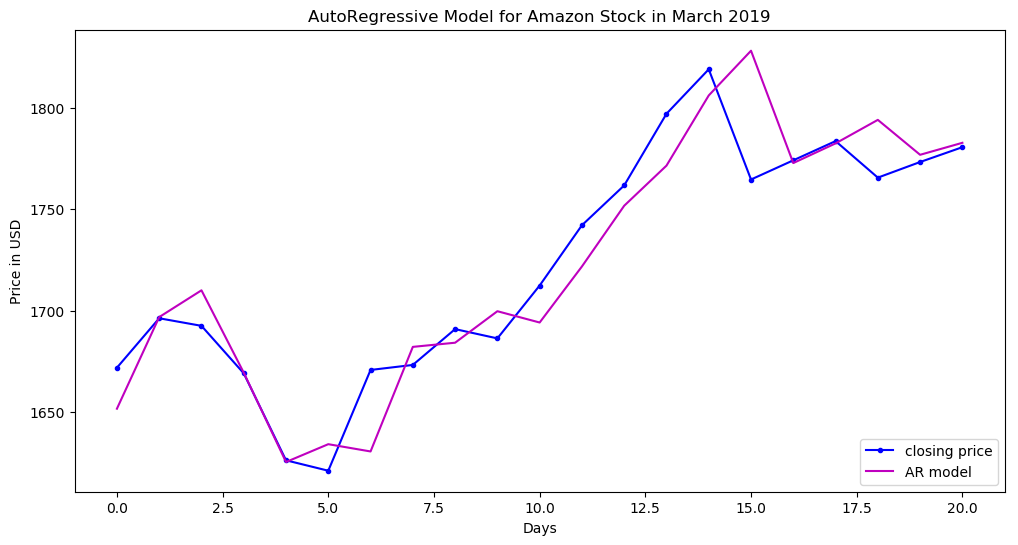

In [24]:
using PyPlot;
figure(figsize=(12,6));
plot(close_price,"b.-",yestAR,"m-");
legend(["closing price", "AR model"], loc="lower right");
title("AutoRegressive Model for Amazon Stock in March 2019");
xlabel("Days");
ylabel("Price in USD");


### Strategy ###

As previously stated, traders often utilize some derivative of the moving average model (source: https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp). The autoregressive model indicates when to buy and sell stock when the prediction curve crosses the actual data. For example the first time the AR model cross the closing price curve, it would indicate to the trader to sell his/her stock. The next time the AR model crosses the closing price, the trader would then buy the stock, and repeat this process. 

## 4. Regularization Model ##


## 4a. Regularization Mathematical Model ##

Following the creation of a general model for buying and purchasing stocks, it became clear that the model could be made more realistic by accounting for the trading fees that are generally charged for buying and selling stock. To do so, we created a regularization model in which the tradeoff parameter, lambda, represented the cost of buying or selling a given stock. As with the moving average model, this model was on a month of closing price data from Amazon.

In addition to converting the model to a regularization problem, two arrays of integer decision variables, buyCount and sellCount were added to the model. These track whether or not stock was purchased or sold on a given day within the month.The regularization program's general model is shown below.

$$
\begin{aligned}
\underset{x \in \mathbb{R^n}}{\text{minimize}}\qquad& f_0(x) + lambda*(sellCount + buyCount)\\
\text{Decision Variables:}\\
& hold[i] >= 0\\
& cash[i] >= 0\\
& sell[i] >= 0\\
& sellCount[i] = 0,1\\
& buyCount[i] = 0,1\\
\text{subject to:}\\
& hold[1] == buy [1], \\
& cash[1] == initialCash - (values[1]*buy[1])\\
& sell[1] == 0 ,\\
& values[1] * buy[1] <= initialCash ,\\
& hold[i] == hold[i-1] + buy[i] - sell[i],\\
& cash[i] == cash[i-1] + sum(values[i] * sell[i]) - sum(values[i] * buy[i])),\\
& sum(buy[i] * values[i]) <= cash[i],\\
& sell[i] <= hold[i - 1],\\
& sell[i] <= sellCount[i]*100,\\
& buy[i] <= buyCount[i]*100\\
&i=1,\dots,d
\text{        (Where d is the number of trading days in the month)}
&
\end{aligned}
$$


Finally, the program results at different values of lambda were used to create a Pareto plot. This plot and other results will be further described in the results section.

## 4b. Regularization Solution ##

Below is the expanded model, programmed in Julia. The model has been programmed as a function, to allow multiple instances to be run when creating a Pareto curve for the regularization problem. Using Pyplot, the objective value is plotted for a range of values from 0 to 10,000. This leads to a graph of discrete point groupings, as the model is an integer program. Although a maximum lambda value of $10,000 may be unrealistic for the price of completing a trade, values up to this level are included to illustrate the mathematical concept, and to represent the cost of acquiring information.

In [1]:
"""Below is code to import Amazon stock data for March 2019"""

using JuMP, Cbc, NamedArrays, CSV

#Daily Amazon stock closing values for an entire month.
raw1 = CSV.read("AMZN.csv")
values = raw1[:,2]


""" Below is a function containing the regularization model."""
#array for each day that Amazon stock was traded over the course of the month.
days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

#Initial starting cash value of $100,000.
initialCash = 100000

function solveOpt(lambda)
    m = Model(solver=CbcSolver())
    
    #Amount of Amazon stock sold for each day of the month.
    @variable(m, sell[days] >= 0, Int)
    
    #Amount of Amazon stock bought for each day of the month.
    @variable(m, buy[days] >= 0, Int)
    
    #Amount of Amazon stock held for each day of the month.
    @variable(m, hold[days] >= 0, Int)
    
    #Amount of cash held for each day of the month
    @variable(m, cash[days] >= 0)
    
    #tracks whether or not stock sales were made in a given day of the month
    @variable(m, sellCount[days], Bin)
    
    #tracks whether or not stocks were bought on a given day of the month
    @variable(m, buyCount[days], Bin)
    
    #ensures that the amount of stock held after day one is equal to the amount of stock bought on day one
    @constraint(m, hold_initial, hold[1] == buy[1])
    #constrains the amount of cash held after day 1
    @constraint(m, cash[1] == initialCash - (values[1] * buy[1]))
    #sets the amount of stock sold on day one to zero
    @constraint(m, sell_initial, sell[1] == 0)
    #ensures that the stock bought on day one doesn't exceed the initial amount of cash held
    @constraint(m, values[1] * buy[1] <= initialCash)
    #constrains the amount of stock held on each day of the month
    @constraint(m, hold_constraint[i in 2:21], hold[i] == hold[i - 1] + buy[i] - sell[i])
    #constrains the amount of cash held on each day of the month
    @constraint(m, cash_constraint[i in 2:21], 
                cash[i] == cash[i - 1] 
                        + sum(values[i] * sell[i])
                        - sum(values[i] * buy[i]))
    #ensures that value of stock bought on a given day doesn't exceed the amount of cash held
    @constraint(m, buy_constraint[i in 2:21], sum(buy[i] * values[i]) <= cash[i])
    #ensures that the value of stock sold on a given day doesn't exceed the amount of stock held
    @constraint(m, sell_constraint[i in 2:21], sell[i] <= hold[i - 1])
    
    #sets sellCount and buyCount to show if the stock was bought or sold on each day
    for i in days
        @constraint(m, sell[i] <= sellCount[i]*100)
        @constraint(m, buy[i] <= buyCount[i]*100)
    end

    #maximizes value of cash held at end of month minus fees for buying and selling stock
    @objective(m, Max, cash[21] - lambda*(sum(sellCount) + sum(buyCount)))
    solve(m)

    returnVal = getobjectivevalue(m)
    sellVal = getvalue(sell)
    buyVal = getvalue(buy)
    holdVal = getvalue(hold)
    
    #cash at end of 21 days
    J1 = getvalue(cash[21])
    
    #total number of trades in 21 days
    J2 = getvalue(sum(sellCount))+getvalue(sum(buyCount))
    return (J1, J2)
end
;


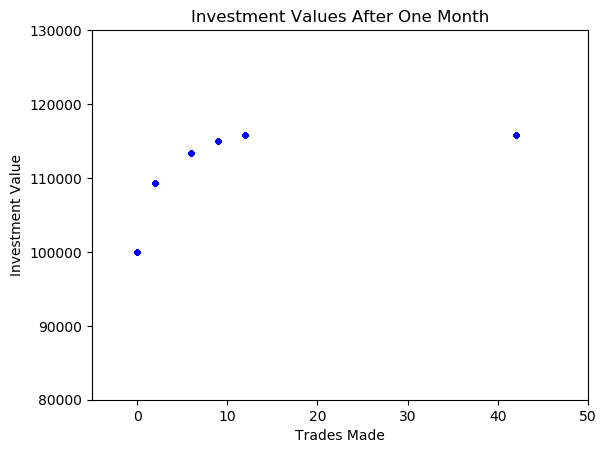

PyObject Text(0.5, 24.0, 'Trades Made')

In [3]:
Npts = 50
J1 = zeros(Npts)
J2 = zeros(Npts)

using PyPlot
for (i,λ) in enumerate(range(0,10000,length=Npts))
    (J1[i],J2[i]) = solveOpt(λ)
    plot(J2, J1, "b.")
end

axis((-5,50, 80000, 130000))

title("Investment Values After One Month")
ylabel("Investment Value")
xlabel("Trades Made")


## 4c. Regularization Results ##

As previously mentioned, a Julia function was used to run the repeatedly run the optimization model with different lambda values. Doing so led to the above Pareto diagram, which displays the ending investment value on the y-axis, and the total number of trades made on the x-axis. The values furthest to the right correspond with the lowest lambda values, and those on the left correspond with the highest lambda values. This is due to higher values of lambda lead to less trades being made, and a resultingly lower final investment value.

## 5. Conclusion ##

This project develops a complex mathematical model for determining the optimal operations (buying and selling) in the stock market. For the purposes of our project, we used the NASDAQ 500 for our market of choice, but the concepts and results from this optimization project can be used in any market. The results of our optimization problem could help a user:

1. Determine the best amount to buy and sell particular stock with a certain amount of initial capital.
2. Predict the future possible trend of price of a particular stock.
3. Show how the return is affected when the user must endure some cost to make a trade.

The following models (in order) is how our project is structured:
1. Base model with its assumptions tells how we measure the cash return.
2. Moving Average and Autoregressive Model gives trader an insight on when to buy and sell stocks properly. It makes prediction based upon previous price information.
3. Regularization model added trade-off which to make the model more realistic.

Our future improvement to this program would be to increase the accuracy of predictions that the model is trying to make. For now, we are using the data from one week in March 2019. Adding more data and constraints is a way to improve our mathematical model. The stock market in real life is more complicated than we thought. Investment banks use tons of data to produce mathematical model and also use various detailed constraints to schedule the selling and buying actions. Our model can provide a general idea about how to attain profits from stock market. However, there will be more work to do if we want to apply the model to real stock market.
 


